In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import re
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

users_df = pd.read_csv('takehome_users.csv',encoding = 'latin-1')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [2]:
users_eng_df = pd.read_csv('takehome_user_engagement.csv',encoding = 'latin-1')

In order to be able to use all data, created a column called 'shifted'. That does the following:
    
    1. Groups all the users together by user_id
    2. creates a shifted column
    3. shifts their timestamp values 2 places.  
    4. Then we convert the two time fields to actual timestamp dtypes
    5. We calculate the tiem diff between the time_stamp col and shifted col
    5 If that timediff is 3 or less days then add that user to the list.
    
Break the cell below up into each line and view the df as it gets changed form line to line to better understand.

In [3]:
users_eng_df['shifted'] = users_eng_df.groupby(['user_id'])['time_stamp'].shift(2)
users_eng_df['time_stamp']= pd.to_datetime(users_eng_df['time_stamp'])
users_eng_df['shifted']=pd.to_datetime(users_eng_df['shifted'])
users_eng_df['time_diff']=users_eng_df['time_stamp']-users_eng_df['shifted']
users_eng_df = users_eng_df[users_eng_df['time_diff']<datetime.timedelta(days=3)]
user_Ids = users_eng_df.user_id.unique()

Manually encode some categorical variables.  For email domain and org_id I only take the make prevalant and
then bin the rest.  I also change org_id to object dtype.

In [4]:
users_df['IsInvited'] = users_df['invited_by_user_id'].apply(lambda x: 1 if x.is_integer() else 0)
users_df['IsAdoptedUser'] = users_df['object_id'].apply(lambda x: 1 if (x in user_Ids) else 0)
users_df['domain'] = users_df['email'].str.extract(r'(@[\w.]+)')
doms = ['@gmail.com', '@yahoo.com', '@jourrapide.com', '@cuvox.de',
       '@gustr.com', '@hotmail.com']
users_df['domain'] = users_df['domain'].apply(lambda x: x if (x in doms) else 'other')
users_df['org_id'] = users_df['org_id'].apply(lambda x: x if (x < 11) else 99)
users_df['org_id'].astype = 'object'

In [5]:
users_df = users_df[['opted_in_to_mailing_list','enabled_for_marketing_drip','domain','creation_source','org_id','IsInvited','IsAdoptedUser']]
users_df = pd.get_dummies(users_df,columns=['domain','creation_source','org_id'])

create my x and y with pop

In [6]:
y =  users_df.pop('IsAdoptedUser')
X = users_df

use smote to upsample my data to balance the dataset

In [7]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [8]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3, random_state=42)

The next several cells are for hyperparameter tuning with hyperopt.
I could have done gridsearchcv but it would have taken much longer.

In [9]:
# Create the parameter grid based on the results of random search 
num_folds=3
n_iter=50
random_state = 42


In [10]:
kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

In [11]:
def objective_func(params, random_state=random_state, cv=kf, x_train=X_train, y_train=y_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'max_features': int(params['max_features']),
              'min_samples_leaf': int(params['min_samples_leaf']),
             'min_samples_split': int(params['min_samples_split'])}
    
    # we use this params to create a classifier
    clf = RandomForestClassifier(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(clf, x_train, y_train, cv=cv, scoring="precision", n_jobs=-1).mean()

    return score

In [ ]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 5000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'min_samples_split': hp.quniform('min_samples_split', 1, 15, 1),
       'max_features': hp.quniform('max_features', 2, 5, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=objective_func, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

print(best)

 14%|█▍        | 7/50 [02:28<16:46, 23.42s/trial, best loss: -0.6011135213232909]

End HPO

Build model with best params

In [21]:
model_grid = RandomForestClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                              min_samples_leaf=int(best['min_samples_leaf']),
                              max_features=int(best['max_features']),
                      max_depth=int(best['max_depth']),min_samples_split=int(best['min_samples_split']))
model_grid.fit(X_train,y_train)
print("model score: %.3f" % model_grid.score(X_test, y_test))

model score: 0.634


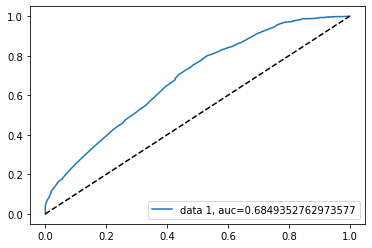

In [22]:
y_pred_proba = model_grid.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=4)
plt.show()

In [23]:
y_pred = model_grid.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.51      0.58      3246
           1       0.61      0.76      0.67      3221

    accuracy                           0.63      6467
   macro avg       0.64      0.63      0.63      6467
weighted avg       0.64      0.63      0.63      6467



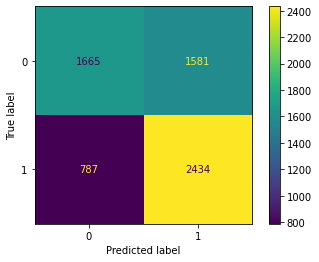

In [25]:
plot_confusion_matrix(model_grid, X_test, y_test)  
plt.show()  # doctest: +SKIP

In [26]:
feature_importances = pd.DataFrame(model_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

In [27]:
feature_importances

,importance
org_id_0,0.098741
creation_source_PERSONAL_PROJECTS,0.091296
enabled_for_marketing_drip,0.080138
org_id_1,0.077198
opted_in_to_mailing_list,0.070223
org_id_99,0.057850
org_id_2,0.052619
org_id_3,0.039551
org_id_4,0.039271
domain_@yahoo.com,0.033657
